<a href="https://colab.research.google.com/github/HimashiRathnayake/Hate-Speech-Humor-Detection/blob/branch-1/Temp/Humor_Hate_Speech_BaseLine_CNN_RNN_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Hate Speech Detection & Humor Detection for Code-mixed Sinhala-English Data </h1>

# User Parameters

In [50]:
Host = "colab" #@param ["colab", "AWS", "GCP"]
technique = "humor" #@param ["humor", "hate speech"]

Account = "colab_datapirates" #@param["colab_datapirates", "colab_lahiru_cse", "colab_lahiru_personal"]
EMBEDDING_SIZE = 300 #@param [50, 150, 200, 250, 300, 350, 400, 450, 500]
embedding_type = "fasttext" #@param ["fasttext","word2vec"]
experiment_no = "9" #@param [] {allow-input: true}
model_type = "LSTM" #@param ["RNN","GRU", "LSTM", "BiLSTM" ]
over_sampling_technique = "SMOTE" #@param ["", "ROS","ADASYN", "SMOTE", "BorderlineSMOTE"]

stack_modeles = "" #@param ["","2","3"]
apply_CNN = False #@param {type:"boolean"}

model_name = model_type + "_model"
if(stack_modeles == "2" or stack_modeles == "3"):
  model_name = "stacked_" + model_name + "_" + stack_modeles
if(apply_CNN):
  model_name = "CNN_" + model_name

if technique == "humor" :
  NO_OUTPUT_LAYERS = 2
  tag_set = ["Humorous", "Non-Humorous"]
elif technique == "hate speech":
  NO_OUTPUT_LAYERS = 3
  tag_set = ["Abusive", "Hate-Inducing", "Not offensive"]

print(model_name + " for " + technique + " detection")

LSTM_model for humor detection


# Folder Paths

In [51]:
folder_path = "/content/drive/Shareddrives/FYP/"
data_path = "/content/drive/Shareddrives/FYP-CodeStars/" + "Annotations/Final/All_tagged_data/çompleted_draft.csv"

context = 5
word_embedding_path = folder_path + "Embedding models/" + embedding_type + '/' + str(EMBEDDING_SIZE) + "/embedding_" + embedding_type + "_" + str(EMBEDDING_SIZE)
word_embedding_keydvectors_path = folder_path + "Embedding models/" + embedding_type + '/' + str(EMBEDDING_SIZE) + "/keyed_vectors/" +  "embedding_" + embedding_type + "_" + str(EMBEDDING_SIZE)
embedding_matrix_path = "/content/drive/Shareddrives/FYP-CodeStars/" + "Humor_HateSpeech detection/Implementation/embedding_matrix/"+embedding_type+'_'+str(EMBEDDING_SIZE)

experiment_name = str(experiment_no) + "_"+ model_name +"_"+embedding_type+"_"+str(EMBEDDING_SIZE)+"_"+str(context)
model_save_path = folder_path + "Humor_HateSpeech detection/Implementation/saved_models/"+technique+"/"+experiment_name+".hdf5"

# Dependencies

In [52]:
# !pip uninstall keras-nightly
# !pip uninstall -y tensorflow
# !pip install h5py==2.10.0  
# !pip install tensorflow==1.15.2
# !pip install q keras==2.3.1
# !pip install dkpro-cassis > /dev/null

In [53]:
from __future__ import print_function

import collections
import pickle
import re
import random
import sys
import os 
import time

import gensim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.fasttext import FastText
from gensim.models import word2vec

from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,precision_recall_fscore_support
from sklearn.utils import shuffle

import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
from numpy import cumsum

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import keras
from keras import backend as K
from keras.models import Sequential,Model,load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout, Activation, Flatten, \
    Embedding, Convolution1D, MaxPooling1D, AveragePooling1D, \
    Input, Dense, merge, Add,TimeDistributed, Bidirectional,SpatialDropout1D
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.regularizers import l2, l1_l2
from keras.constraints import maxnorm
from keras import callbacks
from keras.utils import generic_utils,plot_model
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

from google.colab import data_table
from google.colab import drive

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE

In [54]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Add TPU Support**

In [55]:
apply_TPU_support = True #@param {type:"boolean"}

In [56]:
if (apply_TPU_support):
  print("Tensorflow version " + tf.__version__)

  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  # tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 1.15.2
Running on TPU  ['10.13.224.202:8470']
INFO:tensorflow:Querying Tensorflow master (grpc://10.13.224.202:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 18003099894277640054)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 10727418138066444671)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15914127869695712331)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 14026266371226254488)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 19782935217440893

# Load Data

In [57]:
all_data = pd.read_csv(data_path)

if (technique == "humor"):
  all_data = all_data[['Sentence', 'Humor']]
elif (technique == "hate speech"):
  all_data = all_data[['Sentence', 'Hate_speech']]
else:
  all_data = all_data[['Sentence', 'Offensive']]

all_data.columns = ['Sentence', 'Label']
data_table.DataTable(all_data, include_index=False, num_rows_per_page=10)

,Sentence,Label
0,Ammage Adarayta❤️Eka Dawasak Madi Neda❤️🙏❤️,Non-humorous
1,We need IPL Champions leak data offers ..pleas...,Non-humorous
2,#VPN #ummmaaa #proud_be,Non-humorous
3,chandimal.. uuu thama mulu tem ekama kaaa gaha...,Non-humorous
4,sltgo,Non-humorous
...,...,...
13513,Me mase web family plus packge eke total eka 6...,Non-humorous
13514,munge Dan data kapana widiye awulk thiyenwa,Non-humorous
13515,I didn't received loyalty data past months. Pl...,Non-humorous
13516,worst service ever!!! stolen more than 10GB fr...,Non-humorous


In [58]:
output_labels = all_data['Label'].unique()
print('Output Labels:', output_labels)

label_group =  all_data.groupby('Label')['Label'].count()
print(label_group)

Output Labels: ['Non-humorous' 'Humorous']
Label
Humorous         1305
Non-humorous    12213
Name: Label, dtype: int64


## Count Tokens

In [59]:
# data_path = folder_path + "corpus/new/preprocess_from_isuru/gossip_lanka_all_comments.csv"
# # "corpus/new/preprocess_from_isuru/lankadeepa_comments_with_article_2.csv"
# data = pd.read_csv(data_path)

# def count_tokens(pandas_df):

#   count = 0
#   for index, row in pandas_df.iterrows():
#     comment_words,article_words = 0,0
#     if (type(row['comment']) == str) :
#       comment_words = len(row['comment'].split())
#     # if (type(row['article']) == str) :
#     #   article_words = len(row['article'].split())
#     count += (comment_words + article_words)
#   return count

# tokens = count_tokens(data)
# print(tokens)

In [60]:
# all_data_path = folder_path + 
# "corpus/new/tagged_comments_all_with_punctuation_marks.csv" done
# "corpus/new/tagged_comments_all_with_punctuation_marks_question_only.csv"
# corpus/new/tagged_comments_all_without_punctuation_marks.csv

# all_data = pd.read_csv(all_data_path)

## Some other Preprocessing 

In [61]:
# all_data['comment'] = all_data['comment'].str.replace('?', '')

In [62]:
# all_data.to_csv(folder_path + 'corpus/new/tagged_comments_all_without_punctuation_marks.csv')

In [63]:
# all_data['label'].value_counts()
# set(lankadeepa_data.comment.apply(list).sum())

# Create Input

## comment-label split

In [64]:
# edit this later 
def text_preprocessing(train_data,test_data):
  train_data_texts = train_data['Sentence']
  train_data_labels = train_data['Label']
  test_data_texts = test_data['Sentence']
  test_data_labels = test_data['Label']


  comment_texts = []
  comment_labels = []

  train_text = []
  test_text = []
  train_labels=[]
  test_labels=[]

  for label in train_data_labels:
    if label == "POSITIVE":
      train_labels.append(1)
    else:
      train_labels.append(0)
  comment_labels.append(train_labels)

  for label in test_data_labels:
    if label == "POSITIVE":
      test_labels.append(1)
    else:
      test_labels.append(0)
  comment_labels.append(test_labels)
  

  for comment in train_data_texts:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    train_text.append(lines)
  comment_texts.append(train_text)

  for comment in test_data_texts:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    test_text.append(lines)
  comment_texts.append(test_text)


  return comment_texts,comment_labels

# edit this later 
def text_preprocessing_1(data):
  comments = data['Sentence']
  labels = data['Label']

  comments_splitted = []
  labels_encoded = []

  for label in labels:
    if label == "POSITIVE":
      labels_encoded.append(1)
    else:
      labels_encoded.append(0)

  for comment in comments:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    comments_splitted.append(lines)
  return comments_splitted,labels_encoded


def text_preprocessing_2(data):
  comments = data['Sentence']
  labels = data['Label']

  comments_splitted = []

  for comment in comments:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    comments_splitted.append(lines)

  return comments_splitted,labels

## Takenize and Split Data

In [65]:
comment_texts, comment_labels = text_preprocessing_2(all_data)

# prepare tokenizer

t = Tokenizer()
t.fit_on_texts(comment_texts)
vocab_size = len(t.word_index) + 1
print(vocab_size)

28401


In [66]:
encoded_docs = t.texts_to_sequences(comment_texts)

In [67]:
max_length = len(max(encoded_docs, key=len))
padded_docs = pad_sequences(encoded_docs, maxlen=max_length)
comment_labels = np.array(comment_labels)
padded_docs = np.array(padded_docs)

In [68]:
comment_labels = pd.get_dummies(comment_labels).values
print('Shape of label tensor:', comment_labels.shape)

Shape of label tensor: (13518, 2)


In [69]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, comment_labels, test_size=0.1, random_state=0)

In [70]:
# (unique, counts) = np.unique(y_train, axis=0, return_counts=True)
# print(counts)

## Oversampling

In [71]:
def apply_oversampling(x, y):

  # define oversampling strategy
  if (over_sampling_technique == ""):
    return x, y
  elif (over_sampling_technique == "ROS"):
    oversample = RandomOverSampler()
  elif (over_sampling_technique == "ADASYN"):
    oversample = ADASYN(sampling_strategy="minority")
  elif (over_sampling_technique == "SMOTE"):
    oversample = SMOTE()
  elif (over_sampling_technique == "BorderlineSMOTE"):
    oversample = BorderlineSMOTE()

  # fit and apply the transform
  (unique, counts) = np.unique(y, axis=0, return_counts=True)
  print("Class Distribution Before Oversampling", counts)

  X_over, y_over = oversample.fit_resample(x, y)
  if(technique=="humor"):
    y_over = pd.get_dummies(y_over.flatten())

  (unique, counts) = np.unique(y_over, axis=0, return_counts=True)
  print("Class Distribution After Oversampling", counts)

  return X_over, y_over

In [72]:
# (unique, counts) = np.unique(y_over, return_counts = True)
# frequencies = np.asarray((unique, counts)).T
# print(frequencies)

# Word Embedding

## Generate Embedding Metrix

In [73]:
def generate_embedding_metrix():
  if (embedding_type == 'fasttext'):
    word_embedding_model = FastText.load(word_embedding_path)
  else:
    word_embedding_model = word2vec.Word2Vec.load(word_embedding_path)
    
  word_vectors = word_embedding_model.wv
  word_vectors.save(word_embedding_keydvectors_path)
  word_vectors = KeyedVectors.load(word_embedding_keydvectors_path, mmap='r')

  embeddings_index = dict()
  for word, vocab_obj in word_vectors.vocab.items():
    embeddings_index[word]=word_vectors[word]

  # create a weight matrix for words in training docs
  embedding_matrix = zeros((vocab_size, EMBEDDING_SIZE))
  for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

  pickle.dump(embedding_matrix, open(embedding_matrix_path, 'wb'))
  return embedding_matrix

## Load Embedding Matrix

In [74]:
def load_word_embedding_matrix():
  f = open(embedding_matrix_path, 'rb')
  embedding_matrix= np.array(pickle.load(f))
  return embedding_matrix

# Models

## RNN(LSTM/GRU) model

In [75]:
def RNN_model(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims)(embedding)

    x = Dense(hidden_dims, activation='relu', init='he_normal', 
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output ,name="RNN_model")

    model.compile(loss={'output':'categorical_crossentropy'},
              optimizer=Adadelta(lr=0.95, epsilon=1e-06),
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       f1
                       ])
    
    print(model.summary())
    return model

def stacked_RNN_model_2(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims,return_sequences=True)(embedding)
    x = RNN_layer(hidden_dims)(x)

    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name= "stacked_RNN_model_2")

    model.compile(loss={'output':'categorical_crossentropy'},
          optimizer=Adadelta(lr=0.95, epsilon=1e-06),
          metrics=["accuracy",
                       tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                       f1])

    print(model.summary())
    return model

def stacked_RNN_model_3(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims,return_sequences=True)(embedding)
    x = RNN_layer(hidden_dims,return_sequences=True)(x)
    x = RNN_layer(hidden_dims)(x)

    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name="stacked_RNN_model_3")

    model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=Adadelta(lr=0.95, epsilon=1e-06),
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    f1])

    print(model.summary())
    return model

## CNN+RNN(LSTM /GRU) model 

In [76]:
def CNN_RNN_model(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    conv4 = Convolution1D(NB_FILTERS,
                          4,
                          border_mode='valid',
                          activation='relu',
                          subsample_length=1,
                          name='conv4')(embedding)
    maxConv4 = MaxPooling1D(pool_length=2,
                             name='maxConv4')(conv4)

    conv5 = Convolution1D(NB_FILTERS,
                          5,
                          border_mode='valid',
                          activation='relu',
                          subsample_length=1,
                          name='conv5')(embedding)
    maxConv5 = MaxPooling1D(pool_length=2,
                            name='maxConv5')(conv5)

    x = keras.layers.Concatenate(axis=1)([maxConv4, maxConv5])

    x = Dropout(drop_out_value_2)(x)

    x = RNN_layer(hidden_dims)(x) #rnn_output_size


    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name= "CNN+RNN model")

    model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=Adadelta(lr=0.95, epsilon=1e-06),
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    f1])

    return model

## BiLSTM model 

In [77]:
def BiLSTM_model(maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
  input = Input(shape=(maxlen,))
  embedding = Embedding(MAX_FEATURES, EMBEDDING_SIZE, weights=[EMBEDDING_MATRIX], input_length=maxlen)(input)

  model =  Bidirectional (LSTM (300, return_sequences=True, dropout=drop_out_value_1, kernel_regularizer=l2(0.01)), merge_mode='concat')(embedding)
  model = TimeDistributed(Dense(300, activation='relu'))(model)
  model = Flatten()(model)
  # model = Dense(300, activation='relu')(model) # extra dense layer
  output = Dense(NO_OUTPUT_LAYERS, activation='softmax', name='output')(model)
  model = Model(input, output)

  model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=Adadelta(lr=0.95, epsilon=1e-06),
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                f1])
  
  return model

# Train and Evaluate Model

## Custom F1 Implementation

In [78]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Macro Averages Callback Implementation

In [79]:
class MacroMetrics(Callback):
    def __init__(self, valid_data):
        super(MacroMetrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')

        logs['val_macro_f1'] = _val_f1
        logs['val_macro_recall'] = _val_recall
        logs['val_macro_precision'] = _val_precision
        print("val_macro_precision: %f - val_macro_recall: %f - val_macro_f1: %f" % (_val_precision, _val_recall, _val_f1))
        return

## Train and Validate model

In [80]:
def Train_Model_old(model,X_train, X_test, y_train, y_test):

  print('Training and Testing...')
  test_accs = []
  first_run = True


  acc=[]
  val_acc=[]
  loss=[]
  val_loss=[]
  best_val_acc = 0
  best_test_acc = 0
  for j in range(nb_epoch):
      a = time.time()
      his = model.fit(X_train, y_train,
                      batch_size=batch_size,
                      validation_data=[X_test, y_test],
                      shuffle=True,
                      epochs=1, verbose=verbosity)
      acc+=his.history['accuracy']
      val_acc+=his.history['val_accuracy']
      loss+=his.history['loss']
      val_loss+=his.history['val_loss']
      # print('Epoch %d/%d\t%s' % (j + 1, nb_epoch, str(his.history)))
      if his.history['val_accuracy'][0] >= best_val_acc:
          score, test_acc = model.evaluate(X_test, y_test,
                                      batch_size=batch_size,
                                      verbose=2)
          best_val_acc = his.history['val_accuracy'][0]
          best_test_acc = test_acc
          print('Got best epoch  best val acc is %f test acc is %f' %
                (best_val_acc, best_test_acc))
          if len(test_accs) > 0:
              print('Current avg test acc:', str(np.mean(test_accs)))
      b = time.time()
      cost = b - a
      left = (nb_epoch - j - 1)
      print('One round cost %ds, %d round %ds %dmin left' % (cost, left,
                                                            cost * left,
                                                            cost * left / 60.0))
      test_accs.append(best_test_acc)

  print('Avg test acc:', str(np.mean(test_accs)))
  return model

In [81]:
def Train_Model(model, X_train, y_train, cross_validation = False):

  print('Training and Testing...')

  x_train_train, x_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SPLIT, random_state=0)

  X_over, y_over = apply_oversampling(x_train_train, y_train_train);

  es = EarlyStopping(monitor='val_macro_f1', mode='max', verbose=1, patience=5)
  checkpoint = ModelCheckpoint(model_save_path, monitor='val_macro_f1', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [MacroMetrics(valid_data=(x_val, y_val)), checkpoint , es]

  if (cross_validation):
    callbacks_list = [MacroMetrics(valid_data=(x_val, y_val)), es]

  his = model.fit(X_over, y_over, validation_data=[x_val, y_val], shuffle=True, epochs=NB_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=1)
  return model, his

# Cross Validation

In [82]:
def Do_Cross_Validation(X,y):

  # Define per-fold score containers
  loss_per_fold = []
  acc_per_fold = []
  precision_per_fold = []
  recall_per_fold = []
  f1_per_fold = []

  macro_f1_per_fold = []
  macro_precision_per_fold = []
  macro_recall_per_fold = []

  kfold = KFold(n_splits=FOLDS, shuffle=True)

  for train, test in kfold.split(inputs, targets):
    folds['fold_{}'.format(count)] = {}
    folds['fold_{}'.format(count)]['train'] = train.tolist()
    folds['fold_{}'.format(count)]['test'] = test.tolist()
    count += 1
    print(len(folds) == n_splits)#assert we have the same number of splits
    #dump folds to json
    import json
    with open(folder_path + 'folds.json', 'w') as fp:
        json.dump(folds, fp)

  #load to dict to be used
  with open('folds.json') as f:
      kfolds = json.load(f)

  for key, val in kfolds.items():
      train = val['train']
      test = val['test']

  fold_no = 1
  inputs = X
  targets = y
  
  for train, test in kfold.split(inputs, targets):

    model = build_model()
    # model = RNN_model(GRU, MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    
    # RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    model, his = Train_Model(model, inputs[train], targets[train], cross_validation=True)
 
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)

    y_val_pred = model.predict(inputs[test])
    y_val_pred_cat = (np.asarray(y_val_pred)).round()
    y_val = targets[test]

    # Get performance metrics(macro averages) after each fold
    macro_f1, macro_precision, macro_recall = f1_score(y_val, y_val_pred_cat, average='macro'), precision_score(y_val, y_val_pred_cat, average='macro'), recall_score(y_val, y_val_pred_cat, average='macro')

    print(f"""Score for fold {fold_no}:
     {model.metrics_names[0]} of {scores[0]}; 
     {model.metrics_names[1]} of {scores[1]*100}% ;
     {model.metrics_names[2]} of {scores[2]*100}% ;
     {model.metrics_names[3]} of {scores[3]*100}% ;
     {model.metrics_names[4]} of {scores[4]*100}% ;
     macro precision of {macro_precision*100}% ;
     macro recall of {macro_recall*100}% ;
     macro f1 of {macro_f1*100}% ;
     """)
    
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])
    precision_per_fold.append(scores[2])
    recall_per_fold.append(scores[3])
    f1_per_fold.append(scores[4])

    macro_f1_per_fold.append(round(macro_f1, 6))
    macro_precision_per_fold.append(round(macro_precision, 6))
    macro_recall_per_fold.append(round(macro_recall, 6))

    # Increase fold number
    fold_no = fold_no + 1

  # == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f"""> Fold {i+1} - 
    Loss: {loss_per_fold[i]} - 
    Accuracy: {acc_per_fold[i]}% - 
    Precesion: {precision_per_fold[i]}% - 
    Recall: {recall_per_fold[i]}% - 
    F1: {f1_per_fold[i]}%
    Macro Precision: {macro_precision_per_fold[i]}%
    Macro Recall: {macro_recall_per_fold[i]}%
    Macro F1: {macro_f1_per_fold[i]}%
    """)
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Precision: {np.mean(precision_per_fold)}')
  print(f'> Recall: {np.mean(recall_per_fold)}')
  print(f'> F1: {np.mean(f1_per_fold)}')
  print(f'> Macro Precision: {np.mean(macro_precision_per_fold)}')
  print(f'> Macro Recall: {np.mean(macro_recall_per_fold)}')
  print(f'> Macro F1: {np.mean(macro_f1_per_fold)}')
  print('------------------------------------------------------------------------')

# Plot Graphs

In [83]:
def Plot_graphs(metric,val_metric,metric_name):

  epochs=range(len(metric)) # Get number of epochs

  if metric_name == "accuracy":
    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Accuracy", "Validation Accuracy"])

    plt.figure()

  elif metric_name == "loss" :
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Validation Loss"])

    plt.figure()

  elif metric_name == "f1" :
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation F1')
    plt.xlabel("Epochs")
    plt.ylabel("F1")
    plt.legend(["F1", "Validation F1"])

    plt.figure()


  # Expected Output
  # A chart where the validation loss does not increase sharply!

# Main Method

## Set Hyper-Parameters

In [84]:
# EMBEDDING_MATRIX = generate_embedding_metrix()
EMBEDDING_MATRIX = load_word_embedding_matrix()

In [85]:
MAX_FEATURES = EMBEDDING_MATRIX.shape[0] #vocab_size
VERBOSITY = 1
VALIDATION_SPLIT = 0.1
NB_EPOCHS = 10
FOLDS = 5 #10

BATCH_SIZE = 32 # 64, 128
NB_FILTERS = 200
FILTER_LENGTH = 4 # test with 2,3,4,5
HIDDEN_DIMS = NB_FILTERS * 2
MAX_LEN = max_length #275 #test with other values(only this value work for now)
DROPOUT_VALUE_1 = 0.5 #0.8 #0.3
DROPOUT_VALUE_2 = 0.5
L2_REG= 0.01

RNN = GRU

## Build and Compile Model

In [86]:
def build_model() :
  model = None

  if (model_type == "RNN" or model_type == "GRU" or model_type == "LSTM" ):
    # configure layer
    layer = None
    if (model_type == "RNN"):
      layer = RNN
    if (model_type == "GRU"):
      layer = GRU
    if (model_type == "LSTM"):
      layer = LSTM
    
    # configure architecture
    if (stack_modeles == "2"):
      model = stacked_RNN_model_2(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (stack_modeles == "3"):
      model = stacked_RNN_model_3(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (apply_CNN):
      model = CNN_RNN_model(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    else :
      model = RNN_model(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)

  elif (model_type == "BiLSTM" ):

    # configure architecture
    if (stack_modeles == "2"):
      model = stacked_BiLSTM_model_2(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (stack_modeles == "3"):
      model = stacked_BiLSTM_model_3(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (apply_CNN):
      model = CNN_BiLSTM_model(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    else :
      model = BiLSTM_model(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)

    
  return model

## Train and Test Model (Holdout Method)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_2 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

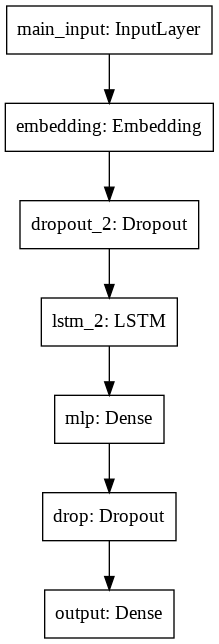

In [87]:
if (apply_TPU_support):
  with tpu_strategy.scope():
    model = build_model()
else:
  model = build_model()
# model = stacked_RNN_model_3(LSTM, MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
plot_model(model,to_file="./model.png")

### Train Model

Training and Testing...
Class Distribution Before Oversampling [9898 1051]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Class Distribution After Oversampling [9898 9898]
Train on 19796 samples, validate on 1217 samples
Epoch 1/10
19796/19796 [==============================] - 930s 47ms/step - loss: 0.3495 - accuracy: 0.8555 - precision: 0.8127 - recall: 0.8127 - f1: 0.8555 - val_loss: 0.4169 - val_accuracy: 0.8094 - val_precision: 0.8410 - val_recall: 0.8410 - val_f1: 0.8141
val_macro_precision: 0.550913 - val_macro_recall: 0.570670 - val_macro_f1: 0.556431

Epoch 00001: val_macro_f1 improved from -inf to 0.55643, saving model to /content/drive/Shareddrives/FYP/Humor_HateSpeech detection/Implementation/saved_models/humor/9_LSTM_model_fasttext_300_5.hdf5
Epoch 2/10
19796/19796 [==============================] - 931s 47ms/step - loss: 0.3048 - accuracy: 0.8728 - precision: 0.8479 - recall: 0.8479 - f1: 0.8727 - val_loss: 0.5084 - val_accuracy: 0.7823 - val_precision: 0.8543 - val_recall: 0.8543 - val_f1: 0.7877
val_macro_precision: 0.548500 - val_macro_recall: 0.581348 - val_macro_f1: 0.552515

Epoch 0000

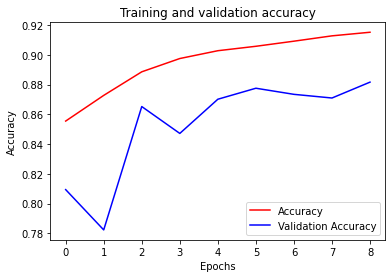

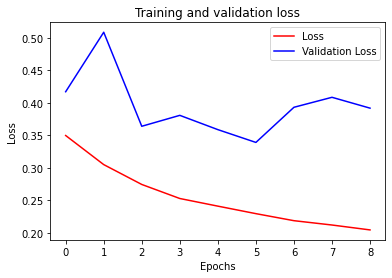

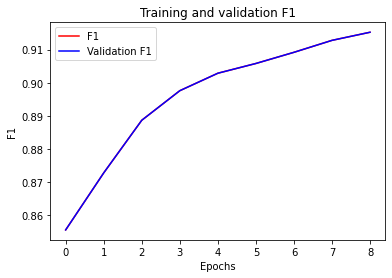

<Figure size 432x288 with 0 Axes>

In [ ]:
# # trained_model = Train_Model_old(model,X_train, X_test, y_train, y_test)
if (apply_TPU_support):
  with tpu_strategy.scope():
    trained_model, his = Train_Model(model, X_train, y_train, cross_validation = False)

    accuracy = his.history['accuracy']
    val_accuracy = his.history['val_accuracy']
    loss = his.history['loss']
    val_loss = his.history['val_loss']
    f1 = his.history['f1']
    val_f1 = his.history['f1']
    val_macro_f1 = his.history['val_macro_f1']

    Plot_graphs(accuracy,val_accuracy, "accuracy")
    Plot_graphs(loss,val_loss, "loss")
    Plot_graphs(f1, val_f1, "f1")

In [ ]:
# #os.kill(os.getpid(), 9)
# exit()

In [ ]:
# from keras.models import Sequential,Model,load_model
# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,precision_recall_fscore_support

# experiment_no = 100
# model_name = "RNN"
# experiment_name = folder_path + "Sentiment Analysis/CNN RNN/experiments/" + model_name +str(experiment_no)+"_"+embedding_type+"_"+str(embedding_size)+"_"+str(context)

# model_save_path = folder_path + "Sentiment Analysis/CNN RNN/saved_models/weights_best_"+model_name+"_"+embedding_type+"_"+str(embedding_size)+"_"+str(experiment_no)+".hdf5"

### Test Model

#### Load Weights to Model

In [88]:
model_save_path = folder_path + "Humor_HateSpeech detection/Implementation/saved_models/" + technique + "/"+ experiment_no +"_" + model_type + "_model_fasttext_300_5.hdf5"

print("Load model from "+model_save_path)
loaded_model  = keras.models.load_model(model_save_path, custom_objects={"f1": f1}, compile=False)
print("loaded " + loaded_model.name)

# _, train_acc,train_f1 = loaded_model.evaluate(X_train, y_train, verbose=1)
# _, test_acc,test_f1= loaded_model.evaluate(X_test, y_test, verbose=1)
# print('Train_acc: %.3f, Test_acc: %.3f, Train_f1: %.3f,  Test_f1: %.3f' % (train_acc, test_acc,train_f1,test_f1))

Load model from /content/drive/Shareddrives/FYP/Humor_HateSpeech detection/Implementation/saved_models/humor/9_LSTM_model_fasttext_300_5.hdf5
loaded RNN_model


#### Get Predictions

In [89]:
predictions = loaded_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)

labels = np.argmax(y_test, axis=1)
predictions = np.argmax(predictions, axis=1)

cm = confusion_matrix(labels,predictions )

# classification_report
report = classification_report(labels, predictions, digits=4,output_dict=True)
report_print = classification_report(labels, predictions, digits=4)
print(report_print)

# save report to drive
report_save_path = folder_path + "Humor_HateSpeech detection/Implementation/reports/"+model_name+"_"+technique+"_"+ experiment_no+"_report.csv"
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(report_save_path)

1352/1352 [==============================] - 19s 14ms/step
              precision    recall  f1-score   support

           0     0.3217    0.3459    0.3333       133
           1     0.9280    0.9204    0.9242      1219

    accuracy                         0.8639      1352
   macro avg     0.6249    0.6331    0.6288      1352
weighted avg     0.8684    0.8639    0.8661      1352



In [90]:
train_data_original, test_data_original = train_test_split(all_data, test_size=0.1, random_state=0)

predictions_series = pd.Series(predictions)
predictions_1 = pd.get_dummies(predictions_series).idxmax(1)

In [91]:
data_frame = pd.DataFrame({'Sentence': test_data_original['Sentence'], 'Label': test_data_original['Label'], 'Predictions': np.array(predictions_1)})

def apply_label_name(value):
  return tag_set[value]

data_frame["Predictions"] = data_frame["Predictions"].apply(apply_label_name)

prediction_save_name  = folder_path + "Humor_HateSpeech detection/Implementation/predictions/"+model_name+"_"+technique+"_"+ experiment_no+"_predictions_with_labels.csv"
data_frame.to_csv(prediction_save_name)
data_table.DataTable(data_frame, include_index=False, num_rows_per_page=10)

,Sentence,Label,Predictions
12114,මේක තමයි හොඳම වංචාව.,Non-humorous,Non-Humorous
3505,frree da,Non-humorous,Non-Humorous
13156,Alawwata gendoooo,Non-humorous,Non-Humorous
2364,Balummhara fiber diyan labba,Non-humorous,Non-Humorous
1136,Enjoy good times streaming with the Automatic ...,Non-humorous,Non-Humorous
...,...,...,...
9997,නැතහොත් SLT පාරිභෝගිකයන් ඉක්මනින් වෙනත් ආයතනයක...,Non-humorous,Non-Humorous
16,හොඳ වැඩේ....මෙයැයිලගේ හැටි දන්නෑ ඔයැයිලා....❤️...,Humorous,Humorous
578,Now I bought 1Gb but free 1 Gb is not there??,Non-humorous,Non-Humorous
2305,හරීම ලස්සනයි මෙහෙම හොද පුතාලත් ලෝකයේ ඉන්නවා,Non-humorous,Non-Humorous


### Print confusion matrix

In [94]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

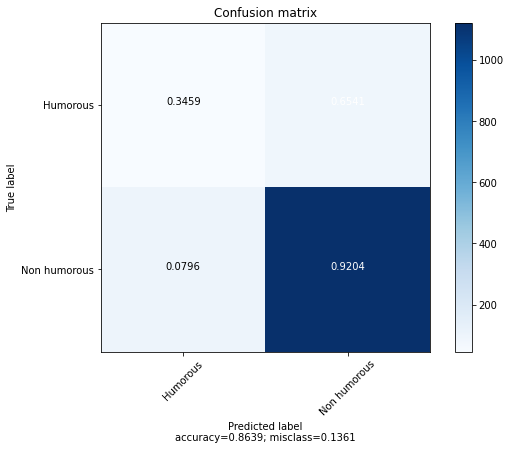

In [95]:
if (technique=="humor"):
  plot_confusion_matrix(cm, ["Humorous","Non humorous"], normalize=True)
else:  
  plot_confusion_matrix(cm, ["Abusive","Hate-Inducing","Not offensive"], normalize=False)

## Train and Test Model (Cross Validation)

In [ ]:
with tpu_strategy.scope():
  Do_Cross_Validation(padded_docs, comment_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_2 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 3)                 12

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train on 26460 samples, validate on 1082 samples
Epoch 1/10
26460/26460 [==============================] - 1231s 47ms/step - loss: 0.6562 - accuracy: 0.7278 - precision_1: 0.7061 - recall_1: 0.5862 - f1: 0.7144 - val_loss: 0.5196 - val_accuracy: 0.7856 - val_precision_1: 0.7651 - val_recall_1: 0.6799 - val_f1: 0.7822
val_macro_precision: 0.450488 - val_macro_recall: 0.639571 - val_macro_f1: 0.482702
Epoch 2/10
 3744/26460 [===>..........................] - ETA: 17:22 - loss: 0.4062 - accuracy: 0.8387 - precision_1: 0.7708 - recall_1: 0.6895 - f1: 0.8318

KeyboardInterrupt: ignored

# Hyperparameter Tuning

In [ ]:
def tune_hyperparameters(model_build_fn):
  # fix random seed for reproducibility
  seed = 7
  np.random.seed(seed)

  model = KerasClassifier(build_fn=model_build_fn, maxlen=MAX_LEN, hidden_dims=HIDDEN_DIMS, l2_reg= L2_REG, verbose=VERBOSITY)

  # optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
  maxlen_list  = [210]
  hidden_dims_list = [300, 400, 500, 600]
  l2_reg_list = [0.01, 0.02]
  drop_out_value_list = [0.5, 0.8]
  # tune for kernal size 2,3,4,5

  param_grid = dict(RNN_layer = [LSTM], maxlen=maxlen_list, hidden_dims = hidden_dims_list, l2_reg= l2_reg_list, drop_out_value_1 = drop_out_value_list, drop_out_value_2 = l2_reg_list)
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=FOLDS, verbose = 10 )
  grid_result = grid.fit(padded_docs, comment_labels)

  # summarize results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# tune_hyperparameters(RNN_model)